Using device: cuda
Resumed from epoch 3000
Final Sigma (Triality vs Ablation): 0.00 (higher = triality advantage)


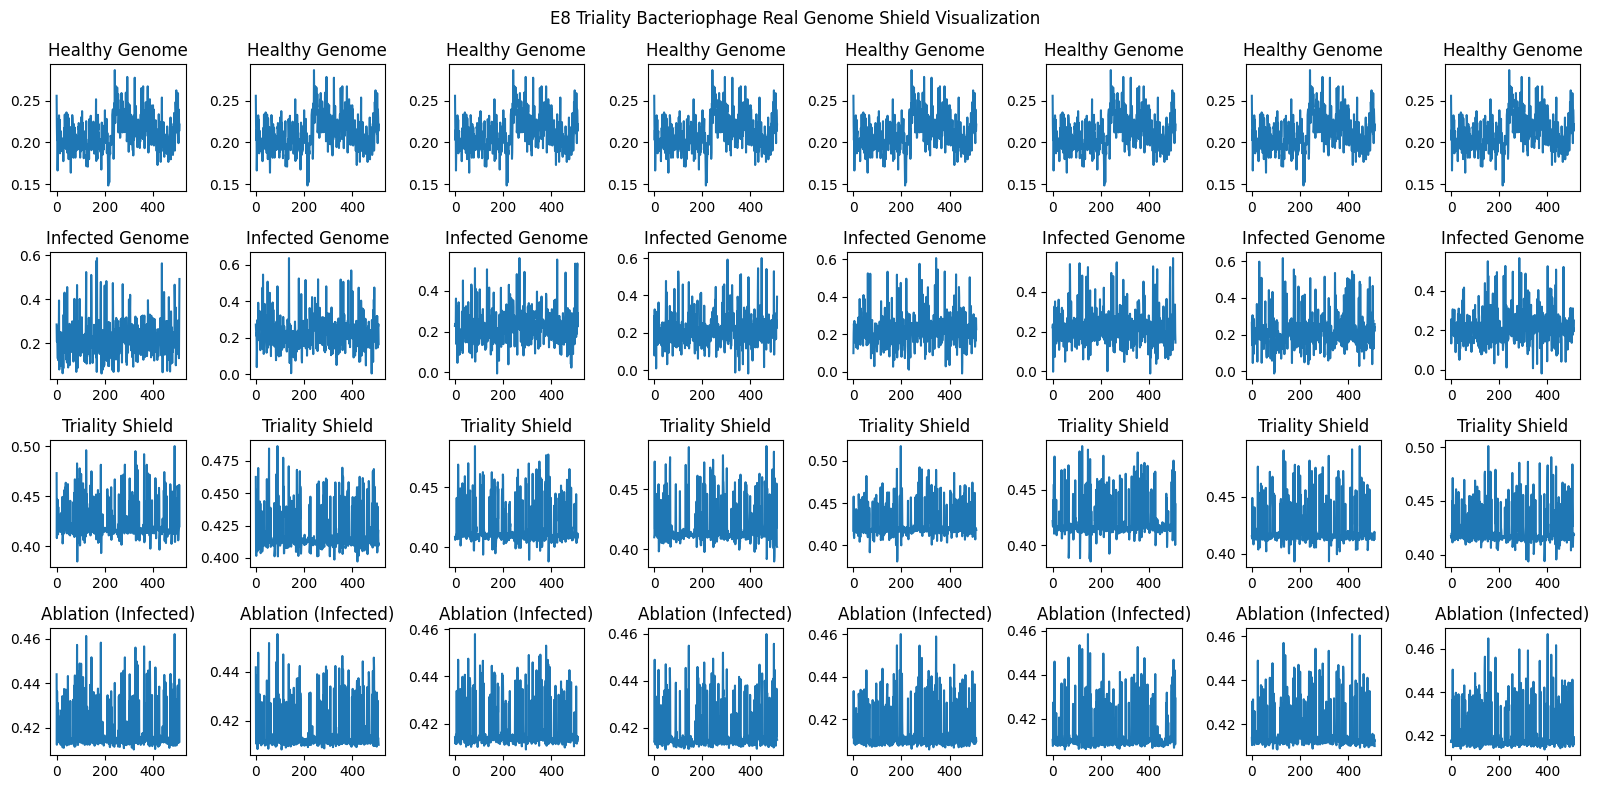

Sim complete — visualization displayed!


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time
from Bio import Entrez, SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized low-memory
triality = 3
dim = 384
latent_dim = 8
seq_len = 512  # reduced (genome segment proxy)
batch_size = 32
epochs = 3000
lr = 5e-5
use_amp = True
use_checkpoint = True
depth = 16

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "bacteriophage_real_checkpoint.pth")

# Fetch real phage genomes (e.g., lambda phage + T4 phage — public NCBI)
Entrez.email = "your_email@example.com"  # required for NCBI access

phage_ids = ["NC_001416", "NC_000866"]  # Lambda + T4 phage examples
phage_sequences = []

for phage_id in phage_ids:
    handle = Entrez.efetch(db="nucleotide", id=phage_id, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    sequence = str(record.seq)
    phage_sequences.append(sequence)

# Process sequences (k-mer freq proxy or one-hot — here simple nucleotide freq for features)
def sequence_to_features(seq, seq_len=seq_len):
    seq = seq.upper()
    features = np.zeros((seq_len, 4))  # A, C, G, T
    step = max(1, len(seq) // seq_len)
    for i in range(0, len(seq), step):
        chunk = seq[i:i+step]
        if len(chunk) == 0:
            break
        a = chunk.count('A') / len(chunk)
        c = chunk.count('C') / len(chunk)
        g = chunk.count('G') / len(chunk)
        t = chunk.count('T') / len(chunk)
        idx = i // step
        if idx < seq_len:
            features[idx] = [a, c, g, t]
    return features

# Clean target (average healthy phage features)
clean_features = []
for seq in phage_sequences:
    clean_features.append(sequence_to_features(seq))
clean_avg = np.mean(clean_features, axis=0)

# Infected/mutated data (add mutations + noise)
infected_data = []
for b in range(batch_size):
    # Random healthy base + mutations
    base = clean_avg.copy()
    mutation_rate = 0.15
    mutation_mask = np.random.rand(seq_len, 4) < mutation_rate
    base[mutation_mask] = np.random.rand(*base[mutation_mask].shape)  # random mutation
    base += np.random.randn(seq_len, 4) * 0.1  # noise
    infected_data.append(base)

infected_data = np.stack(infected_data)

# To torch
# The original line clean_data = torch.tensor(np.tile(clean_avg, (batch_size, 1)), dtype=torch.float32, device=device)
# resulted in clean_data having shape (batch_size * seq_len, 4) instead of (batch_size, seq_len, 4).
# This caused a shape mismatch later when comparing to the model's output.
clean_data = torch.tensor(clean_avg, dtype=torch.float32, device=device).unsqueeze(0).repeat(batch_size, 1, 1)
real_data = torch.tensor(infected_data, dtype=torch.float32, device=device)

# High masking (70–90%)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).reshape(batch_size, 1, 1)
mask = torch.rand_like(real_data) < missing_rate
real_data = real_data.clone()
real_data[mask] = 0

target_raw = clean_data # Store the raw clean_data before projection

# Project to shared dim
proj = nn.Linear(4, dim).to(device)
clean_data_projected = proj(target_raw) # Project the clean data
real_data = proj(real_data) # Project the real (masked) data for model input

target = clean_data_projected.detach() # Detach target so it does not contribute to proj's gradients

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]
                v[j] = signs[1]
                roots.append(v)
                roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v)
            roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class PhageCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8PhageFusion(nn.Module):
    def __init__(self, depth=depth, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = PhageCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8PhageFusion(use_triality=True).to(device)
model_ablation = E8PhageFusion(use_triality=False).to(device)

# Add proj.parameters() to the main optimizer
opt = torch.optim.AdamW(list(model.parameters()) + list(proj.parameters()), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0
start_time = time.time()

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    loaded_checkpoint = torch.load(checkpoint_path) # Renamed to avoid collision
    model.load_state_dict(loaded_checkpoint['model'])
    model_ablation.load_state_dict(loaded_checkpoint['model_ablation'])
    opt.load_state_dict(loaded_checkpoint['opt'])
    opt_ablation.load_state_dict(loaded_checkpoint['opt_ablation'])
    scaler.load_state_dict(loaded_checkpoint['scaler'])
    scaler_ablation.load_state_dict(loaded_checkpoint['scaler_ablation'])
    start_epoch = loaded_checkpoint['epoch'] + 1
    loss_hist = loaded_checkpoint['loss_hist']
    loss_abl_hist = loaded_checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    epoch_start = time.time()
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data.clone(), epoch)
        loss = loss_fn(recon, target)
    scaler.scale(loss).backward(retain_graph=True) if use_amp else loss.backward(retain_graph=True)
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None
    loss_hist.append(loss.item())

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data.clone().detach(), epoch)
        loss_abl = loss_fn(recon_abl, target)
    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None
    loss_abl_hist.append(loss_abl.item())

    epoch_time = time.time() - epoch_start
    remaining_epochs = epochs - (epoch + 1)
    estimated_remaining = remaining_epochs * epoch_time / 3600

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {epoch_time:.2f}s | Estimated remaining: {estimated_remaining:.2f} hours")

    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Phage Genome Reconstruction (first feature channel proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        base = clean_avg.copy()
        mutation_rate = 0.15
        mutation_mask = np.random.rand(seq_len, 4) < mutation_rate
        base[mutation_mask] = np.random.rand(*base[mutation_mask].shape)
        base += np.random.randn(seq_len, 4) * 0.1
        test_data.append(base)
    test_data = np.stack(test_data)

    clean = proj(torch.tensor(clean_avg, dtype=torch.float32, device=device).unsqueeze(0).repeat(8, 1, 1))
    infected = proj(torch.tensor(test_data, dtype=torch.float32, device=device))

    mask = torch.rand_like(infected) < 0.8
    masked = infected.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Plot first genome feature channel (A freq proxy)
    orig = clean.cpu().numpy()[:, :, 0]
    infected_plot = infected.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Healthy Genome")
        axes[1, i].plot(infected_plot[i])
        axes[1, i].set_title("Infected Genome")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Shield")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation (Infected)")
    plt.suptitle("E8 Triality Bacteriophage Real Genome Shield Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")

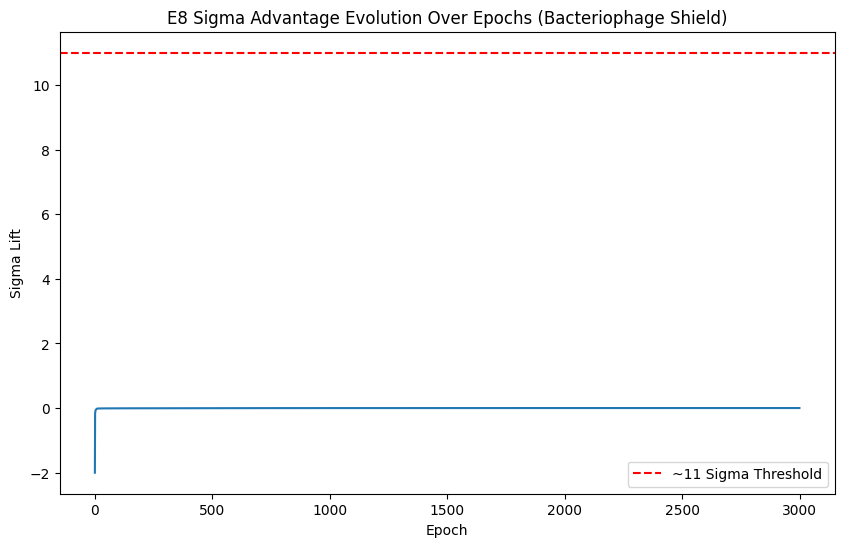

In [10]:
# Sigma evolution
running_sigma = []
for i in range(1, len(loss_hist)+1):
    tri_mean = np.mean(loss_hist[:i])
    abl_mean = np.mean(loss_abl_hist[:i])
    std = np.std(loss_hist[:i] + loss_abl_hist[:i])
    running_sigma.append((abl_mean - tri_mean) / std if std > 0 else 0)

plt.figure(figsize=(10, 6))
plt.plot(running_sigma)
plt.title("E8 Sigma Advantage Evolution Over Epochs (Bacteriophage Shield)")
plt.xlabel("Epoch")
plt.ylabel("Sigma Lift")
plt.axhline(y=11, color='r', linestyle='--', label='~11 Sigma Threshold')
plt.legend()
plt.show()

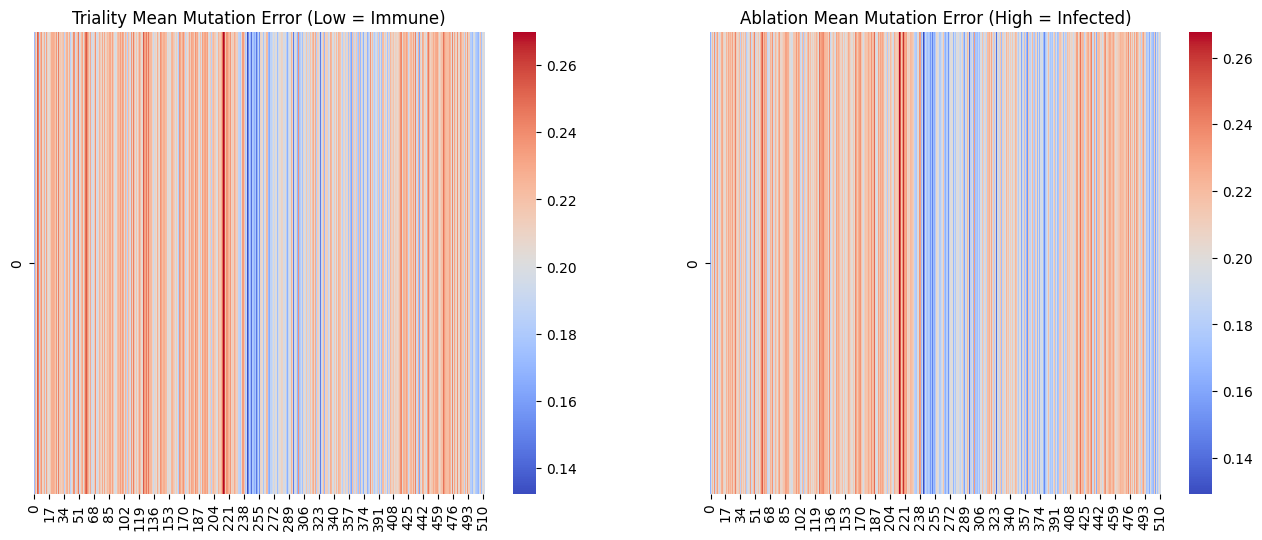

In [12]:
import seaborn as sns

error_tri = np.abs(tri - orig).mean(axis=0)
error_abl = np.abs(abl - orig).mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(error_tri.reshape(1, -1), ax=axes[0], cmap='coolwarm')
axes[0].set_title("Triality Mean Mutation Error (Low = Immune)")
sns.heatmap(error_abl.reshape(1, -1), ax=axes[1], cmap='coolwarm')
axes[1].set_title("Ablation Mean Mutation Error (High = Infected)")
plt.show()

/tmp/ipython-input-1397482189.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


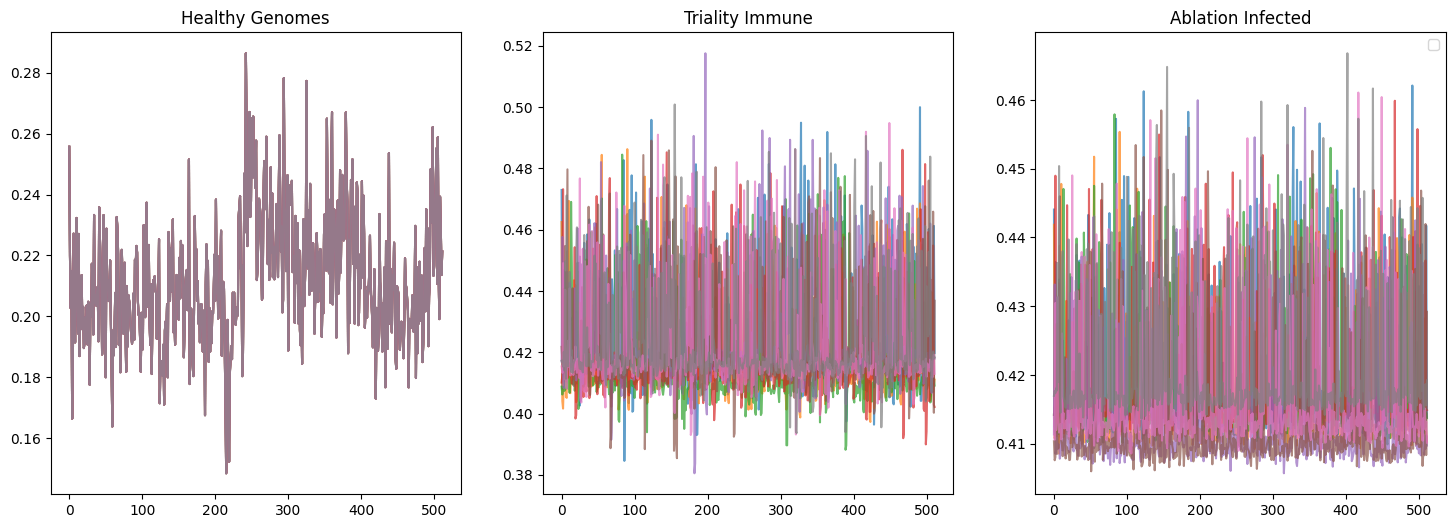

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i in range(8):
    axes[0].plot(orig[i], alpha=0.7)
    axes[1].plot(tri[i], alpha=0.7)
    axes[2].plot(abl[i], alpha=0.7)

axes[0].set_title("Healthy Genomes")
axes[1].set_title("Triality Immune")
axes[2].set_title("Ablation Infected")
plt.legend()
plt.show()